In [19]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy import special
plt.rc('animation', html='jshtml')

In [20]:
class P_dist_handler():
    k_b = 1.380649e-23
    T0 = 273.15
    def __init__(self, x_min, x_max, N=2000, p_func=None, Y=None) -> None:
        self.p_func = p_func
        self.Y = Y
        self.x_max = x_max
        self.x_min = x_min
        self.p_dist = None
        self.N = N
        self.func = None

    def get_expectation_value(self, operator, args=None):
        if self.p_func == None:
            if self.p_dist == None:
                self.p_dist = self.get_p_distribution(args=args)
                #print(self.p_dist)
                return np.mean(operator(self.p_dist))
            else:
                return np.mean(operator(self.p_dist))
        else:
            self.func = lambda x: operator(x)*self.p_func(x, *args)
            return self.direct_integration(func=self.func)
    
    def direct_integration(self, func):
        exp_val = quad(func, self.x_min, self.x_max)[0]
        return exp_val

    def metro_montecarlo(self):
        pass
    
    def montecarlo(self, args):
        p_dist = []
        xs = np.linspace(self.x_min, self.x_max, self.N)
        #p_array = np.linspace(self.x_min, self.x_max, self.N*5)
        for x in xs:
            p = np.random.rand(1)
            if p <= self.Y(x, args[0], args[1], args[2]):
                p_dist.append(x)
        return np.array(p_dist)

    def get_p_distribution(self, args):
        if self.p_func == None:
            if self.Y == None:
                return self.metro_montecarlo(args=args)
            else:
                return self.montecarlo(args=args)    
        else:
            return self.p_func

class H_pot():
    k_b = 1.380649e-23
    T0 = 273.15
    def __init__(self,
            T, 
            k=1.0,
            x_0=0.0, 
            p_handler=None
            ) -> None:
        
        self.T = T
        self.beta = 1.0/(self.k_b*T)
        self.k = k
        self.x_0 = x_0
        self.v_func = lambda x: 1.0/2.0*self.k*(x-self.x_0)**2
        self.v_avg = None
        self.v_avg_squared = None
        self.cv = None
        self.p_handler = p_handler

    @property
    def get_v_avg(self):
        if self.p_handler == None:
            raise Exception("No p_handler has been assigned yet, so probabilities cannot be computed")
        else:
            if self.v_avg == None:
                self.v_avg = self.p_handler.get_expectation_value(operator=self.v_func, args=(self.T, self.k, self.x_0))
            else:
                pass
    
    @property
    def get_v_avg_squared(self):
        if self.p_handler == None:
            raise Exception("No p_handler has been assigned yet, so probabilities cannot be computed")
        else:
            if self.v_avg_squared == None:
                v_op_squared = lambda x: self.v_func(x)**2
                self.v_avg_squared = self.p_handler.get_expectation_value(v_op_squared, args=(self.T, self.k, self.x_0))
            else:
                pass
    
    def clear_p_handler(self, new_p_handler=None):
        self.cv = None
        self.v_avg = None
        self.v_avg_squared = None
        self.p_handler = new_p_handler

    def get_cv(self, method="analytical", T_step=1e-5):
        if self.cv == None:
            if method == "analytical":
                if self.v_avg == None:
                    self.get_v_avg
                if self.v_avg_squared == None:
                    self.get_v_avg_squared
                #print(self.v_avg, self.v_avg_squared)
                self.cv = self.T0/(self.T**2)*(self.v_avg_squared - self.v_avg**2)
                return self.cv

            if method == "finite_difference":
                #v_step = lambda x: self.v_func(x=x+x_step)
                v_e_step = self.p_handler.get_expectation_value(operator=self.v_func, args=(self.T, self.k+T_step, self.x_0))
                if self.v_avg == None:
                    self.v_avg = self.get_v_avg
                self.cv = (v_e_step - self.v_avg)/T_step
                return self.cv
            #else:
            #    raise Exception("METHOD FOR EVALUATION CV is not defined")
        else:
            return self.cv

    def plot(self, ax, plot_range=[-4.0, 4.0]):
        xs = np.linspace(plot_range[0], plot_range[1], 400)
        ax.plot(xs, self.v_func(xs), color="C0")
        if self.v_avg == None:
            self.get_v_avg
        ax.plot(xs, np.linspace(self.v_avg, self.v_avg, len(xs)), color="C1")
        if self.p_handler.p_func == None:
            pass
        else:
            ax.plot(xs, self.p_handler.p_func(xs, self.T, self.k, self.x_0), color="red")

In [21]:
def p_fun(x,T,k,x_0):
    T0 = 273.15
    t1 = np.sqrt((T0*k)/(2.0*np.pi*T))
    t2 = np.exp(-T0/2.0*k*(x-x_0)**2/T)
    return t1*t2

ks = [1.0, 1.0, 10.0]
x0s = [0.0,1.0, 0.0]
T = 0.5*273.15
Hs = []
for k, x0 in zip(ks, x0s):
    p_handler = P_dist_handler(x_min=x0-6, x_max=x0+6, p_func=p_fun)
    h = H_pot(T=T, k=k, x_0=x0, p_handler=p_handler)
    Hs.append(h)

## a) 
Plot the potential of the harmonic oscillator with some different values for the force constant, $k$. Plot the probability distribution. Evaulate the thermally averaged potential energy by direct integration in a finite range from some $x_{min}$ to some $x_{max}$. Neglect for now that this leads to a small error.

0.24999999999999964
0.24999999999999964
0.25000000000000006


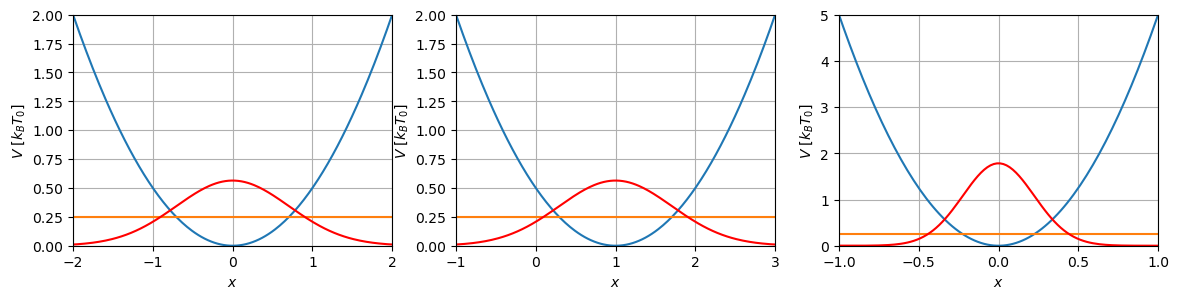

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
x_lims = [[-2,2],[-1,3],[-1,1]]
y_lims = [[0,2], [0,2], [0,5]]
xs = np.linspace(-2.0, 2.0, 1000)
#Y = lambda x, T, k, x_0, x_min, x_max: np.sqrt(k/(2.0*np.pi))*np.exp(-k/2.0*(x-x_0)**2)/special.erf(x_max*np.sqrt(k/2.0)) #+ 1.0/(x_max-x_min)
for ax, x_lim, y_lim, pot, k, x0 in zip(axs, x_lims, y_lims, Hs, ks, x0s):
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$V$ $[k_BT_{0}]$")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    pot.plot(ax)
    print(pot.v_avg)

#I think the probababilty distributions are wrong, but i cannot recreat bjørks distributions even if i renormalize?

In [23]:
for pot in Hs:
    pot.clear_p_handler()

def p_fun(x,T,k,x_0):
    T0 = 273.15
    t1 = np.sqrt((T0*k)/(2.0*np.pi*T))
    t2 = np.exp(-T0/2.0*k*(x-x_0)**2/T)
    return t1*t2

def Y(x, T, k, x_0):
    T0 = 273.15
    return np.exp(-T0/2.0*k*(x-x_0)**2/T)
#Y = lambda x, T, k, x_0: np.sqrt(k/(2.0*np.pi))*np.exp(-k/2.0*(x-x_0)**2) + 1.0/(8.0)
x0s = [0.0,1.0,0.0]
x_pairs = [[-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0]]
for pot, x0, x_pair in zip(Hs, x0s, x_pairs):
    p_handler = P_dist_handler(x_min=x0+x_pair[0], x_max=x0+x_pair[1], Y=Y, N=20000)
    pot.p_handler = p_handler

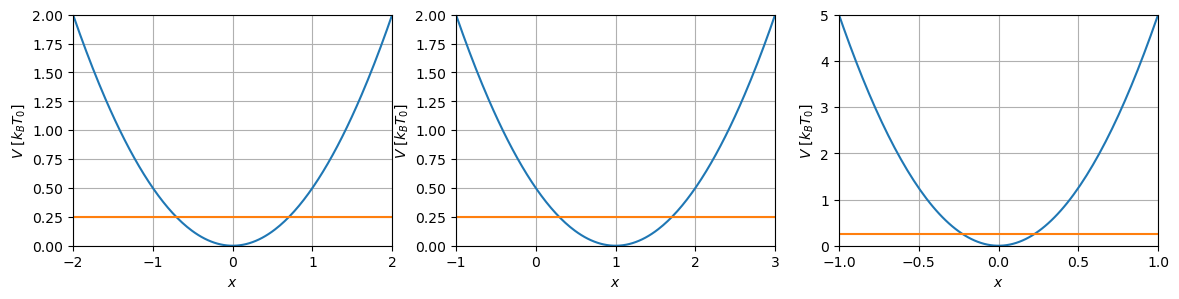

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
x_lims = [[-2,2],[-1,3],[-1,1]]
y_lims = [[0,2], [0,2], [0,5]]

for ax, x_lim, y_lim, pot, k, x0 in zip(axs, x_lims, y_lims, Hs, ks, x0s):
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$V$ $[k_BT_0]$")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    pot.plot(ax)

In [25]:
for pot in Hs:
    pot.clear_p_handler()

T0 = 0.01*273.15
Ts = np.linspace(T0, 500, 500)
cvs = []
for T in Ts:
    Hs[0].T = T
    #print(Hs[0].T)
    p_handler = P_dist_handler(x_min=0.0-4.0, x_max=0.0+4.0, p_func=p_fun)
    Hs[0].p_handler = p_handler
    cv = Hs[0].get_cv("analytical")
    cvs.append(cv)
    #print(cv)
    Hs[0].cv = None
    Hs[0].v_avg = None
    Hs[0].v_avg_squared = None

-0.6513869178197851

In [420]:
deltax=abs(2.0-(-2.0))
np.random.rand(100)*deltax-2.0

array([-1.16560521, -0.08896552,  0.67277464,  1.54642472, -0.88173544,
       -1.15510875, -1.71630939, -1.34350453,  0.25278493, -1.45266621,
       -0.8532081 ,  1.72659324,  1.6229186 , -1.47149635,  0.86567903,
        1.29443281, -1.91749639,  0.27021363, -1.96582853, -0.42136767,
       -0.12308601,  1.03728081,  1.26310005, -0.41322184, -1.48301496,
        0.26827848, -1.02551065,  1.65817001,  0.33507107,  1.36277846,
       -1.96763072, -0.23774619,  1.06125412,  1.01030803,  0.45056588,
        1.91534535,  0.47092184,  0.54513793,  1.34136248,  0.2685451 ,
        0.14159306, -0.36362304,  0.91127725, -0.00990121,  0.51350207,
        1.99761525, -0.0150984 ,  0.17929429,  1.75495287, -0.90973351,
       -0.93561344,  1.70100823, -1.37512521,  1.65234959,  1.72207776,
       -0.58980011, -0.62075824,  1.63139682,  0.69936081,  1.16899169,
        0.66987968,  0.78648395,  1.30000131, -0.65833135,  1.81249058,
       -0.62500139,  1.29012621,  0.87131304,  1.76810422,  0.30